# Parameterizing MD correlation functions

In the previous section, we learned how to derive order parameters and correlation functions from an MD trajectory. Now, the question is, how do we acquire NMR rate constants from the correlation functions. To begin, we give the formula for a few rate constants.

$$
\begin{eqnarray}
R_1^I&=& \left(\frac{\delta^{IS}}{4}\right)^2(J(\omega_I-\omega_S)+3J(\omega_I)+6J(\omega_I+\omega_S))+\frac13(\omega_I\Delta\sigma_I)^2J(\omega_I)\\
R_2^I&=& \frac12R_1^I+\left(\frac{\delta^{IS}}{4}\right)^2(J(\omega_S)+2J(0)+\frac29(\omega_I\Delta\sigma_I)^2J(0)\\
\Gamma_{IS}&=& \left(\frac{\delta^{IS}}{4}\right)^2(-J(\omega_I-\omega_S)+6J(\omega_I+\omega_S))
\end{eqnarray}
$$

These yield the orientationally averaged rate constants, which is relevant in solids where the relaxation is multiexponential. The critical terms are the sizes of the interactions ($\delta^{IS}$, $\omega_I\Delta\sigma_I$), and the frequencies at which the spectral densities are sampled (0, $\omega_S$, $\omega_I$, $\omega_I\pm\omega_S$).

The spectral density itself is given by the real part of the Fourier transform, that is:

$$
J(\omega)=2\int\limits_0^\infty{C(t)\cos(\omega t)dt}
$$

We usually assume that $C(t)$ is symmetric in time, so that we integrate from 0 instead of $-\infty$, and multiply by 2. A factor of 1/5 needs to appear in the correlation function to account for the isotropic average over starting orientations. This factor is sometime incorporated into the correlation function for overall tumbling, i.e. for isotropic tumbling the correlation function is $C(t)=\frac15\exp(-t/\tau_M)C_{int.}(t)$. What we have calculated in the previous section is $C_{int.}(t)$

We could, in principle, Fourier transform the correlation functions from the previous section directly (after subtracting the order parameter away). Instead, what we usually do is assume the correlation function is a sum of exponentially decaying functions, and fit the corresponding parameters. 

$$
C_{int}(t)=S^2+(1-S^2)\sum\limits_i{A_i\exp(-t/\tau_i)}
$$

For just two correlation times, this is often written as

$$
C_{int}(t)=S^2_fS^2_s+(1-S_f^2)\exp(-t/\tau_f)+S_f^2(1-S_s^2)\exp(-t/\tau_s)
$$

Then, $S^2=S_f^2S_s^2$, $A_f=(1-S_f^2)$, and $A_s=S_f^2(1-S_s^2)$. We'll use the former equation for simplicity.

In this case, the spectral density may be written as follows, noting that the Fourier transform of an exponential is a Lorentzian function

$$
J(\omega)=2\sum\limits_i{\frac{A_i}{1+(\omega\tau_i)^2}}
$$

## Setup
We need to repeat the initial setup performed in the first notebook

In [1]:
# Make sure pyDR is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !git clone https://github.com/alsinmr/pyDR
else:
    os.chdir('../../..')

In [2]:
# imports
import pyDR
from pyDR.Fitting.fit import model_free
from pyDR.MDtools import vft
from pyDR.misc.tools import linear_ex
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from time import time
from copy import copy

In [3]:
# Download the trajectory files
xtc='https://drive.google.com/file/d/1wq5T-YDmPo2zAIWu9we2zyL2i-v52fnD/view?usp=sharing'
pdb='https://drive.google.com/file/d/1aBMUO2C1AZfx05dANl4QITHuqmHbDDsN/view?usp=sharing'

if not(os.path.exists('ubi.pdb')):
    pyDR.IO.download(pdb,'ubi.pdb')
if not(os.path.exists('ubi.xtc')):
    pyDR.IO.download(xtc,'ubi.xtc')

In [4]:
def align(uni,fileout='ubi_aligned.xtc',ref_sel='name CA'):
    """
    This function takes a trajectory and aligns it based on
    a reference selection of atoms. The new trajectory is
    returned in fileout (default is ubi_aligned.xtc)
    """
    
    from scipy.linalg import svd
    
    uni.trajectory[0] #Go to the first frame of the trajectory
    atoms=uni.atoms   #All atoms in the trajectory
    ref_sel=uni.select_atoms(ref_sel)  #Atom group for the reference
    
    ref0=ref_sel.positions #initial positions of reference atoms
    ref0-=ref0.mean(0) #Centers the initial position
    
    with mda.Writer(fileout,atoms.n_atoms) as W:
        for ts in uni.trajectory:
            ref=ref_sel.positions
            pos=atoms.positions

            pos-=ref.mean(0)   #This centers the reference
            ref-=ref.mean(0)   
            
            H=ref0.T@ref       #3x3 matrix
            U,S,Vt=svd(H)      #Singular value decomposition
            V=Vt.T             #Transposes
            Ut=U.T

            R=V@Ut             #Rotation matrix for alignment
            
            pos_corr=(R.T@pos.T).T
            atoms.positions=pos_corr
            
            W.write(atoms)
    return

In [5]:
uni0=mda.Universe('ubi.pdb','ubi.xtc')
if not(os.path.exists('ubi_aligned.xtc')):
    align(uni0,fileout='ubi_aligned.xtc')   #Runs the code to align Ubiquitin in the universe
uni=mda.Universe('ubi.pdb','ubi_aligned.xtc')  #Loads the aligned trajectory

## pyDIFRATE initial data load
We'll work with pyDIFRATE in this notebook. We'll start with a project (`proj=pyDR.Project`) and load NMR data into it which is downloaded online, and also load correlation functions into it from an MD trajectory.

pyDIFRATE does a lot of things for you automatically. The advantage here is that we'll get through the problems more quickly, but the downside is that you'll have to accept that some of the parameters are indeed calculated correctly ;-).

In [6]:
proj=pyDR.Project()
proj.append_data('https://raw.githubusercontent.com/alsinmr/pyDR_tutorial/main/data/ubi_soln.txt')

sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi_aligned.xtc',project=proj)
sel.select_bond('15N')
pyDR.md2data(sel)

sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi.xtc',project=proj)
sel.select_bond('15N')
pyDR.md2data(sel)

# Time axis for correlation functions
data=proj['raw']['MD'][0]
t=data.sens.info['t']  #ns

# Residues in the simulation
resids=data.label

Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed


In [7]:
print(proj)

pyDIFRATE project with 3 data sets

titles:
r:NMR:ubi_soln
r:MD:ubi_aligned
r:MD:ubi



## Plot the spectral density
We can obtain the spectral density via Fourier transform of the correlation function. 

We first note that the correlation functions and order parameters are stored in the project. We plot one for example.

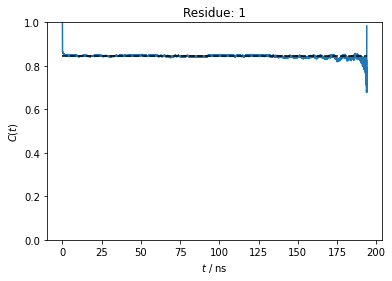

In [8]:
resi=1
i=np.argmax(resids==resi) # Finds where this is true  
data=proj['MD']['raw']['.+aligned']  #Finds the unprocessed MD data

ax=plt.subplots()[1]
ax.plot(t,data.R[i])
ax.plot(t[[0,-1]],np.ones(2)*data.S2[i],color='black',linestyle='--')
ax.set_xlabel(r'$t$ / ns')
ax.set_ylabel(r'$C(t)$')
ax.set_title(f'Residue: {resi}')
_=ax.set_ylim([0,1])

Plot the spectral density for a few residues (code below)

In [9]:
resi=5
i=np.argmax(resids==resi) # Finds where this is true  
Ct=data.R[i]-data.S2[i]
Ct[0]/=2  #Single-sided FT, need to cut first point in half
dt=(t[1]-t[0])*1e-9
J=2*np.fft.fftshift(np.fft.fft(Ct[:len(Ct)//2],n=len(Ct))).real*dt

f=1/(2*dt)*np.linspace(-1,1,len(t))/1e6
f-=(f[1]-f[0])/2

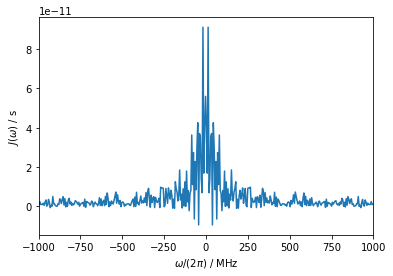

In [10]:
ax=plt.subplots()[1]
ax.plot(f,J)
ax.set_xlabel(r'$\omega/(2\pi)$ / MHz')
ax.set_ylabel(r'$J(\omega)$ / s')
_=ax.set_xlim([-1000,1000])

### Exercise 1.1
Why do we recommend fitting the correlation function rather than taking the correlation function directly?

```{toggle}
The Fourier transform is too noisy to be used to get reliable rate constants. With smoothing or fitting, it can, however, provide reliable results.

We instead fit the correlation function as a multi-exponential decay and use the parameters in the expression above for the spectral density, $J(\omega)$.
```

## Multi-exponential fitting (model-free-like analysis)
We define a class below to extract model free parameters from MD-derived correlation functions.

In [11]:
class MF():
    def __init__(self,n:int=4,aligned:bool=True,Type='MD',proj=proj):
        self._Type=Type
        self.proj=proj
        self._n=None
        self.aligned=aligned
        self._z=None
        self._A=None
        self.fit=None
        self.chi2=None
        self.n=n
    
    @property
    def Type(self):
        return self._Type
    
    @Type.setter
    def Type(self):
        assert 0,'Type (MD/NMR) cannot be changed after initialization'
        
    def _title(self,pre):
        if self.Type=='MD':
            return f'{pre}:MD:ubi'+('_aligned' if self._aligned else '')
        return f'{pre}:NMR:ubi_soln'
                
    @property
    def n(self):
        return self._n
    
    @n.setter
    def n(self,n):
        if hasattr(self,'_n') and n==self._n:
            return
        self._n=n
        if len(proj[self._title(f'p{n}')])==0:
            self.proj[self._title('n12')].detect.r_auto(n=n)
            self.proj[self._title('n12')].fit()
        data=proj[self._title(f'p{n}')][0]
        fixz=[-14,*[None for _ in range(self.nz-1)]] if n%2==1 else None
        z,A,chi2,fit=model_free(data,self.nz,fixz=fixz)
        self.z=z
        self.A=A
        self.fit=fit
        self.chi2=chi2
        
    @property
    def nz(self):
        return np.ceil(self.n/2).astype(int)
        
    @property
    def aligned(self):
        return self._aligned
    
    @aligned.setter
    def aligned(self,aligned):
        if self.Type!='MD':
            return
        if hasattr(self,'_aligned') and self._aligned==aligned:
            return
        self._aligned=aligned
        if len(proj[self._title('n12')])==0:
            proj[self._title('r')].detect.r_no_opt(12)
            proj[self._title('r')].fit()
        if self._n is not None:
            n=self.n    #Force a re-calculation
            self._n=0  
            self.n=n
        
    @property
    def tc(self):
        return 10**self.z
    
    @property
    def S2_fit(self):
        return 1-self.A.sum(0)
    
    @property
    def S2(self):
        if self.Type!='MD':return
        return self.proj[self._title('r')].S2
    
    @property
    def resids(self):
        return self.proj[self._title('r')].label
    
    @property
    def t(self):
        return self.proj['MD']['raw']['ubi_aligned'].info['t'].astype(float)
    
    def plot_pars(self,ax:list=None):
        if ax is None:
            fig,ax=plt.subplots(self.nz,2,sharex=True)
        for k,ax0 in enumerate(ax):
            ax0[0].scatter(self.resids,self.A[k],s=5,color='red')
            ax0[0].set_ylabel('A')
            ax0[1].scatter(self.resids,self.z[k],s=5,color='red')
            ax0[1].set_ylabel(r'$\log_{10}(\tau_c$ / s$)$')
            if ax0[0].is_last_row():
                for a in ax0:a.set_xlabel('Residue')
        
        fig.set_size_inches([8,9])
        fig.tight_layout()
        return ax
    
    @property
    def Ct_fit(self):
        ct=np.ones([len(self.t),len(self.resids)])*self.S2
        for tc0,A0 in zip(self.tc,self.A):
            ct+=np.exp(-np.kron(np.atleast_2d(self.t*1e-9).T,np.atleast_2d(1/tc0)))*A0
        return ct.T
    
    @property
    def Ct(self):
        if self.Type!='MD':return
        return self.proj[self._title('r')].R
    
    def plot_ct(self,resi:int,ax=None):
        if ax is None:
            ax=plt.subplots()[1]
        i=self.resids==resi
        assert np.any(i),'No data for selected residue'
        i=np.argmax(i)
        if self.Type=='MD':
            ax.plot(self.t,self.Ct[i],color='red')
            ax.plot(self.t,self.Ct_fit[i],color='black',linestyle='--')
            ax.legend(('MD','fit'))
        else:
            ax.plot(self.t,self.Ct_fit[i],color='red')
        ax.set_xlabel(r'$t$ / ms')
        ax.set_ylabel(r'$C(t)$')
        ax.set_title(f'Residue: {resi}')

        return ax
        
        
mf=MF()

Fitted 1 data objects
Fitted 1 data objects
Iterations |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%  of 4 steps
Completed


In [12]:
self=mf
S2=1-self.A.sum(0)
ct=np.ones([len(self.t),len(self.resids)])*S2
for tc0,A0 in zip(self.A,self.tc):
    ct+=np.exp(-np.kron(np.atleast_2d(self.t.astype(float)*1e-9).T,np.atleast_2d(1/tc0)))*A0

<AxesSubplot:title={'center':'Residue: 8'}, xlabel='$t$ / ms', ylabel='$C(t)$'>

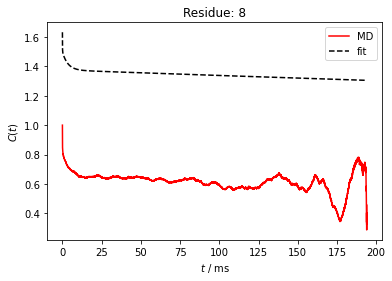

In [20]:
mf.n=7
mf.plot_ct(8)

In [19]:
mf.S2.min()

0.021027982

Iterations |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%  of 16 steps
Completed


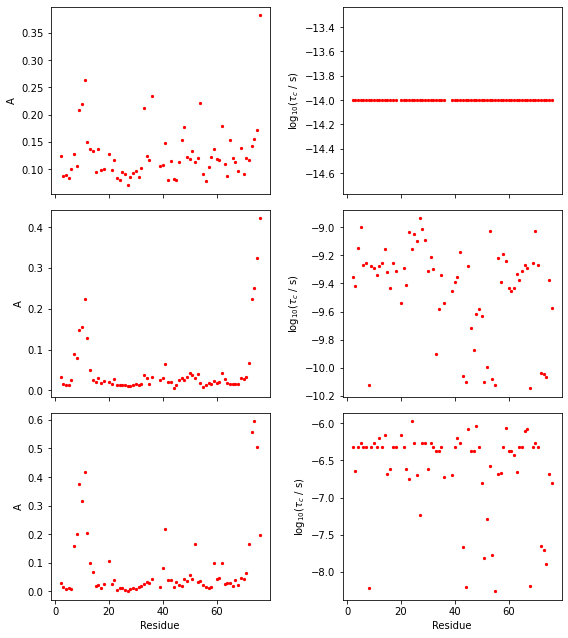

In [41]:
mf.n=5
_=mf.plot_pars()

In [150]:
mf.proj[mf._title.format(f'p{6}')]

pyDIFRATE project with 0 data sets

Titles:


The output above indicates that we have two data sets, one from NMR and one from MD. Both are "raw" (`r`) data, i.e. unprocessed. As we work with this data, you'll find that processing of the data automatically lands in this project.

Below, we define a class that will provide for you 

In [ ]:
class MFana():
    def __init__

In [7]:
proj['MD']['raw'].detect.r_no_opt(12)
proj['MD']['raw'].fit()

Fitted 1 data objects
pyDIFRATE project with 1 data sets

Titles:
n12:MD:ubi_aligned


In [8]:
class MFfit():
        def __init__(self,z,A,error,fit,npars):
            self.npars=npars
            self.z=np.array(z)
            self.A=np.array(A)
            self.error=error
            self.fit=fit
        
        @property
        def S2(self):
            return 1-np.array([A0 for A0 in self.A]).sum(0)
        
        @property
        def tc(self):
            return 10**self.z
        
        def calc_rates(self,sens):
            out=[linear_ex(sens.z,sens.rhoz,z0)*A0 for z0,A0 in zip(self.z,self.A)]
            out=np.array(out).sum(0)
            if hasattr(sens,'R0'):
                out=(out.T+sens.R0).T
            return out
        
        def compare_rates(self,data):
            data.plot(style='p')
            rates=self.calc_rates(data.sens)
            for k,(R,a) in enumerate(zip(rates,data.project.plot_obj.ax)):
                a.scatter(self.fit.label,R,color='black',s=10)
                a.set_ylabel(f'{data.info[k]["Type"]} ({data.info[k]["v0"]})')
                
            return data.project.plot_obj
        
        def plot_fit(self,index=np.linspace(0,72,9).astype(int)):
            n=len(index)
            ax,*_=pyDR.Plotting.subplot_setup(n)
            
            Ct=proj['raw']['MD'][0]
            t=Ct.info['t']
            print(np)
            
            ct=np.array([A0*np.exp(-(t/1e-9)/tc0) for A0,tc0 in zip(self.A,self.tc)]).sum(0)
            ct+=1-self.A[k].sum()
            
            for k,a in enumerate(ax):
                a.plot(t,Ct.R[index[k]],color='red')
                
                
                a.plot(t,Ct,color='black',linestyle=':')
                
            return ax

def MF(npars):
    if len(proj[f'p{npars}:MD:ubi_aligned'])==0:
        data=proj['MD']['no_opt'][0]
        data.detect.r_auto(npars)
        fit=data.fit()
    else:
        fit=proj[f'p{npars}:MD:ubi_aligned'][0]   
    nz=np.ceil(npars/2).astype(int)
    fixz=[-14.,*[None for _ in range(nz-1)]] if np.mod(npars,2) else None
    print(fixz)
    z,A,error,fit=model_free(fit,nz=nz,fixz=fixz)
    return MFfit(z,A,error,fit,npars)
    
def Detectors(npars):
    if len(proj[f'p{npars}:MD:ubi_aligned'])==0:
        data=proj['MD']['no_opt'][0]
        data.detect.r_auto(npars)
        fit=data.fit()
        

In [18]:
t=proj['raw']['MD'].info['t']
ct=np.array([A0*np.exp(-np.kron((t/1e-9),1/tc0)) for A0,tc0 in zip(mf.A,mf.tc)]).sum(0)
ct+=1-self.A[k].sum(0)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

In [19]:
tc0=mf.tc[0]
A0=mf.A[0]

In [9]:
mf=MF(5)

[-14.0, None, None]
1 of 16 iterations
2 of 16 iterations


/Users/albertsmith/Documents/GitHub.nosync/pyDR/Fitting/fit.py:398: RuntimeWarning: invalid value encountered in reciprocal
  pinv=((m**2).sum(1)**(-1))*m.T


3 of 16 iterations
4 of 16 iterations
5 of 16 iterations
6 of 16 iterations
7 of 16 iterations
8 of 16 iterations
9 of 16 iterations
10 of 16 iterations
11 of 16 iterations
12 of 16 iterations
13 of 16 iterations
14 of 16 iterations
15 of 16 iterations
16 of 16 iterations


Text(0, 0.5, 'R1')

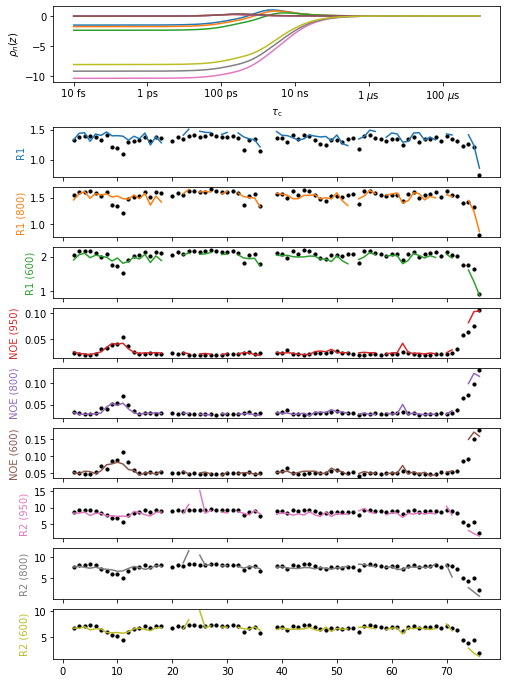

In [10]:
proj.close_fig('all')
mf.__class__=MFfit
mf.compare_rates(proj[0])
proj.fig.set_size_inches([8,12])
proj.plot_obj.ax[0].set_ylabel('R1')

In [14]:
mf.tc.shape

(3, 72)

<module 'numpy' from '/opt/anaconda3/lib/python3.8/site-packages/numpy/__init__.py'>


TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

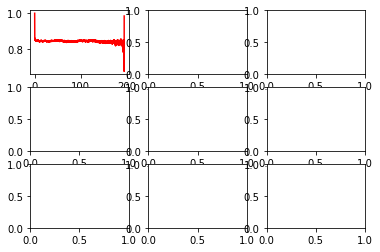

In [11]:
mf.__class__=MFfit
mf.plot_fit()

In [72]:
proj.current=1

In [74]:
proj.plot_obj.fig

AttributeError: 'NoneType' object has no attribute 'fig'